# First Level GLM (from Nilearn)

In this tutorial, we will go through a simple workflow of the first level general linear modeling with a BIDS dataset from openneuro. This analysis is only performed on **one** subject.

This tutorial is based on the [Nilearn GLM tutorial](https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_bids_features.html#sphx-glr-auto-examples-04-glm-first-level-plot-bids-features-py).

In [1]:
import nest_asyncio
nest_asyncio.apply()

## Preparation

Import packages that will be used globally and set up output directory

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import os
import typing as ty
from pathlib import Path

import pydra
from pydra import Workflow
from pydra.engine.specs import File
import pandas as pd
from scipy.stats import norm

import nibabel as nib
from nilearn.datasets import (
        fetch_openneuro_dataset_index,
        fetch_openneuro_dataset,
        select_from_index,
    )
from nilearn.interfaces.fsl import get_design_from_fslmat
from nilearn.glm.first_level import first_level_from_bids
from nilearn.reporting import get_clusters_table, make_glm_report
from nilearn.plotting import (
    plot_glass_brain,
    plot_img_comparison,
    plot_contrast_matrix,
)

In [3]:
# get current directory
pydra_tutorial_dir = os.path.dirname(os.getcwd())

# set up output directory
workflow_dir = Path(pydra_tutorial_dir) / 'outputs'
workflow_out_dir = workflow_dir / '6_glm'

# create the output directory if not exit
os.makedirs(workflow_out_dir, exist_ok=True)

In [4]:
workflow_out_dir

PosixPath('/tmp/outputs/6_glm')

## Create tasks

In this section, we converte major steps into tasks.
Each pydra task can have multiple python functions. We recommand to put those logically more related functions into the same task.

It is very **important** to keep in mind what adjacent tasks of your current task will be.
1. Your previous task will decide your arguments in the current task
2. Your next task will be impacted by the returns in the current task

### fetch openneuro BIDS dataset

In this task, we do the following:
1. get openneuro dataset index
2. specify exclusion patterns and number of subjects
3. download the data we need


**Notes:** Here we still use `n_subjects` as an argument. Given that we will only analyze one subject, you can also remove this argument and specify `n_subjects =1` in `select_from_index`. If you do, do not forget to modify the argument in the workflow later.

In [5]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'exclusion_patterns': list,
        'n_subjects': int,
        'return': {'data_dir': str},
    }
)
def get_openneuro_dataset(exclusion_patterns, n_subjects):
    _, urls = fetch_openneuro_dataset_index()
    urls = select_from_index(
        urls, exclusion_filters=exclusion_patterns, n_subjects=n_subjects
    )
    data_dir, _ = fetch_openneuro_dataset(urls=urls)
    return data_dir

### obtain FirstLevelModel objects automatically and fit arguments

To get the first level model(s) we have to specify
1. the dataset directory
2. the task_label
3. the space_label
4. the folder with the desired derivatives (fMRIPrep)

In our case, we only have one subject so we will only have one first level model.
Then, for this model, we will obtain
1. the list of run images
2. events
3. confound regressors

Those are inferred from the confounds.tsv files available in the BIDS dataset.

In [6]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'data_dir': str,
        'task_label': str,
        'space_label': str,
        'derivatives_folder': str,
        'smoothing_fwhm': float,
        'return': {'model': ty.Any, 'imgs': list, 'subject': str},
    }
)
def get_info_from_bids(
    data_dir, task_label, space_label, smoothing_fwhm, derivatives_folder
):
    (
        models,
        models_run_imgs,
        models_events,
        models_confounds,
    ) = first_level_from_bids(
        dataset_path=data_dir,
        task_label=task_label,
        space_label=space_label,
        smoothing_fwhm=smoothing_fwhm,
        derivatives_folder=derivatives_folder,
    )
    model, imgs, events, confounds = (
        models[0],
        models_run_imgs[0],
        models_events[0],
        models_confounds[0],
    )
    subject = 'sub-' + model.subject_label
    return model, imgs, subject

### Get design matrix

This task does the following:
1. read the design matrix in `.mat`
2. rename the column
3. save the new design matrix as `.csv`

**Think:** What if we don't save the new design matrix, but `return` it directly? In other words, we `return` a `pandas.DataFrame` instead of a `path`. What will happen? Worth a try :)

In [7]:
@pydra.mark.task
@pydra.mark.annotate(
    {'data_dir': str, 'subject': str, 'return': {'dm_path': str}}
)
def get_designmatrix(data_dir, subject):
    fsl_design_matrix_path = os.path.join(
        data_dir,
        'derivatives',
        'task',
        subject,
        'stopsignal.feat',
        'design.mat',
    )
    design_matrix = get_design_from_fslmat(
        fsl_design_matrix_path, column_names=None
    )

    design_columns = [
        'cond_%02d' % i for i in range(len(design_matrix.columns))
    ]
    design_columns[0] = 'Go'
    design_columns[4] = 'StopSuccess'
    design_matrix.columns = design_columns
    dm_path = os.path.join(workflow_out_dir, 'designmatrix.csv')
    design_matrix.to_csv(dm_path, index=None)
    return dm_path

### Fit the first level model

What we are doing here is:
1. use the design matrix to fit the first level model
2. compute the contrast
3. save the z_map and masker for futher use
4. generate a glm report (HTML file)

In [8]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'model': ty.Any,
        'imgs': ty.Any,
        'dm_path': ty.Any,
        'contrast': str,
        'return': {'model': ty.Any, 'z_map_path': str, 'masker': ty.Any, 'glm_report_file': str},
    }
)
def model_fit(model, imgs, dm_path, contrast):
    design_matrix = pd.read_csv(dm_path)
    model.fit(imgs, design_matrices=[design_matrix])
    z_map = model.compute_contrast(contrast)
    z_map_path = os.path.join(workflow_out_dir, 'firstlevel_z_map.nii.gz')
    z_map.to_filename(z_map_path)
    masker_path = os.path.join(workflow_out_dir, 'firstlevel_masker.nii.gz')
    masker = model.masker_
    glm_report_file = os.path.join(workflow_out_dir, 'glm_report.html')
    report = make_glm_report(model, contrast)
    report.save_as_html(glm_report_file)
    return model, z_map_path, masker, glm_report_file

### Get cluster table

For publication purposes, we obtain a cluster table.

In [9]:
@pydra.mark.task
@pydra.mark.annotate({'z_map_path': str, 'return': {'output_file': str}})
def cluster_table(z_map_path):
    stat_img = nib.load(z_map_path)
    output_file = os.path.join(workflow_out_dir, 'cluster_table.csv')
    df = get_clusters_table(
        stat_img, stat_threshold=norm.isf(0.001), cluster_threshold=10
    )
    df.to_csv(output_file, index=None)
    return output_file

### Make plots

Here we want to make some plots to display our results and compare the result from FSL.
1. plot nilearn z-map
2. plot fsl z-map
3. plot nilearn and fsl comparison
4. plot design matrix contrast

You can also seperate this task into multiple sub-tasks. But it makes more sense to put them into one task as they use the same files and function `nilearn.plotting` repeatedly.

In [10]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'data_dir': str,
        'dm_path': str,
        'z_map_path': str,
        'contrast': str,
        'subject': str,
        'masker': ty.Any,
        'return': {
            'output_file1': str,
            'output_file2': str,
            'output_file3': str,
            'output_file4': str,
        },
    }
)
def plots(data_dir,dm_path,z_map_path,contrast,subject,masker):
    # plot and save nilearn z-map
    z_map = nib.load(z_map_path)
    output_file1 = os.path.join(workflow_out_dir, 'nilearn_z_map.jpg')
    plot_glass_brain(
        z_map,
        output_file=output_file1,
        colorbar=True,
        threshold=norm.isf(0.001),
        title='Nilearn Z map of "StopSuccess - Go" (unc p<0.001)',
        plot_abs=False,
        display_mode='ortho',
    )

    # plot and save fsl z-map
    fsl_z_map = nib.load(
        os.path.join(
            data_dir,
            'derivatives',
            'task',
            subject,
            'stopsignal.feat',
            'stats',
            'zstat12.nii.gz',
        )
    )
    output_file2 = os.path.join(workflow_out_dir, 'fsl_z_map.jpg')
    plot_glass_brain(
        fsl_z_map,
        output_file=output_file2,
        colorbar=True,
        threshold=norm.isf(0.001),
        title='FSL Z map of "StopSuccess - Go" (unc p<0.001)',
        plot_abs=False,
        display_mode='ortho',
    )

    # plot and save nilearn and fsl comparison
    plot_img_comparison(
        [z_map],
        [fsl_z_map],
        masker,
        output_dir=workflow_out_dir,
        ref_label='Nilearn',
        src_label='FSL',
    )
    old = os.path.join(workflow_out_dir, '0000.png')
    new = os.path.join(workflow_out_dir, 'nilearn_fsl_comp.jpg')
    os.rename(old, new)
    output_file3 = new
    print(output_file3)

    # plot and save design matrix contrast
    design_matrix = pd.read_csv(dm_path)
    output_file4 = os.path.join(workflow_out_dir, 'firstlevel_contrast.jpg')
    plot_contrast_matrix(contrast, design_matrix, output_file=output_file4)
    return output_file1, output_file2, output_file3, output_file4

## Make a workflow from tasks

Now we have created all tasks we need for this first level analysis, and there are two choices for our next step.
1. create one workflow to connect all tasks together
2. create sub-workflows with some closely related tasks, and connect these workflows along with other tasks into a larger workflow.

We recommand the second approach as it is alway a good practice to group tasks, especially when there are a large number of tasks in the analysis.

Our analysis can be divided into three parts: (1) get/read the data, (2) analyze the data, and (3) plot the result, where (1) and (3) only have one task each. So we can put all tasks in (2) into one workflow and name it as `firstlevel` or whatever you prefer.

In [11]:
# initiate a workflow
wf_firstlevel = Workflow(
    name='wf_firstlevel',
    input_spec=[
        'data_dir',
        'task_label',
        'space_label',
        'derivatives_folder',
        'smoothing_fwhm',
        'contrast',
        'output_dir',
    ],
)

# specify input
wf_firstlevel.inputs.task_label = 'stopsignal'
wf_firstlevel.inputs.space_label = 'MNI152NLin2009cAsym'
wf_firstlevel.inputs.derivatives_folder = 'derivatives/fmriprep'
wf_firstlevel.inputs.smoothing_fwhm = 5.0

# add task - get_info_from_bids
wf_firstlevel.add(
    get_info_from_bids(
        name='get_info_from_bids',
        data_dir=wf_firstlevel.lzin.data_dir,
        task_label=wf_firstlevel.lzin.task_label,
        space_label=wf_firstlevel.lzin.space_label,
        derivatives_folder=wf_firstlevel.lzin.derivatives_folder,
        smoothing_fwhm=wf_firstlevel.lzin.smoothing_fwhm,
    )
)
# add task - get_designmatrix
wf_firstlevel.add(
    get_designmatrix(
        name='get_designmatrix',
        data_dir=wf_firstlevel.lzin.data_dir,
        subject=wf_firstlevel.get_info_from_bids.lzout.subject,
    )
)
wf_firstlevel.add(
    model_fit(
        name='l1estimation',
        model=wf_firstlevel.get_info_from_bids.lzout.model,
        imgs=wf_firstlevel.get_info_from_bids.lzout.imgs,
        dm_path=wf_firstlevel.get_designmatrix.lzout.dm_path,
        contrast=wf_firstlevel.lzin.contrast,
    )
)
# add task - cluster_table
wf_firstlevel.add(
    cluster_table(
        name='cluster_table',
        z_map_path=wf_firstlevel.l1estimation.lzout.z_map_path,
    )
)
# specify output
wf_firstlevel.set_output(
    [
        ('z_map', wf_firstlevel.l1estimation.lzout.z_map_path),
        ('masker', wf_firstlevel.l1estimation.lzout.masker),
        ('subject', wf_firstlevel.get_info_from_bids.lzout.subject),
        ('dm_path', wf_firstlevel.get_designmatrix.lzout.dm_path),
        ('cluster_table', wf_firstlevel.cluster_table.lzout.output_file),
        ('glm_report', wf_firstlevel.l1estimation.lzout.glm_report_file),
    ]
)

## The overaching workflow

Connect other tasks and the above workflow into one

Now we need to create the overaching glm workflow that connects the above workflow and other tasks (e.g., `get/read the data` and `plot the result`)

In [12]:
wf = Workflow(
    name='firstlevel_glm',
    input_spec=['exclusion_patterns', 'n_subjects', 'contrast', 'output_dir'],
)

wf.inputs.exclusion_patterns = [
    '*group*',
    '*phenotype*',
    '*mriqc*',
    '*parameter_plots*',
    '*physio_plots*',
    '*space-fsaverage*',
    '*space-T1w*',
    '*dwi*',
    '*beh*',
    '*task-bart*',
    '*task-rest*',
    '*task-scap*',
    '*task-task*',
]
wf.inputs.n_subjects = 1
wf.inputs.output_dir = workflow_out_dir
wf.inputs.contrast = 'StopSuccess - Go'

wf.add(
    get_openneuro_dataset(
        name='get_openneuro_dataset',
        exclusion_patterns=wf.lzin.exclusion_patterns,
        n_subjects=wf.lzin.n_subjects,
    )
)

wf_firstlevel.inputs.data_dir = wf.get_openneuro_dataset.lzout.data_dir
wf_firstlevel.inputs.contrast = wf.inputs.contrast
wf_firstlevel.inputs.output_dir = wf.inputs.output_dir
wf.add(wf_firstlevel)

wf.add(
    plots(
        name='plots',
        data_dir=wf.get_openneuro_dataset.lzout.data_dir,
        dm_path=wf_firstlevel.lzout.dm_path,
        z_map_path=wf_firstlevel.lzout.z_map,
        contrast=wf.lzin.contrast,
        subject=wf_firstlevel.lzout.subject,
        masker=wf_firstlevel.lzout.masker,
    )
)

wf.set_output(
    [
        ('output1', wf.plots.lzout.output_file1),
        ('output2', wf.plots.lzout.output_file2),
        ('output3', wf.plots.lzout.output_file3),
        ('output4', wf.plots.lzout.output_file4),
    ]
)

## Run Workflow Run

In [13]:
from pydra import Submitter

with Submitter(plugin='cf', n_procs=4) as submitter:
    submitter(wf)

results = wf.result()

print(results)


Dataset created in /home/runner/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed


 ...done. (3 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Downloaded 37560320 of 102374780 bytes (36.7%,    1.7s remaining)

 ...done. (2 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 50487296 of 120927302 bytes (41.8%,    1.4s remaining)

Downloaded 119111680 of 120927302 bytes (98.5%,    0.0s remaining)

 ...done. (2 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


/tmp/outputs/6_glm/nilearn_fsl_comp.jpg

Result(output=Output(output1='/tmp/outputs/6_glm/nilearn_z_map.jpg', output2='/tmp/outputs/6_glm/fsl_z_map.jpg', output3='/tmp/outputs/6_glm/nilearn_fsl_comp.jpg', output4='/tmp/outputs/6_glm/firstlevel_contrast.jpg'), runtime=None, errored=False)


## Visualization

If you arrive here without any errors, yay, you just made your first pydra workflow for a first-level GLM!

## Examine folder structure

Let's take a look at what you have got.

In [14]:
!ls ../outputs/6_glm

cluster_table.csv	 firstlevel_z_map.nii.gz  nilearn_fsl_comp.jpg
designmatrix.csv	 fsl_z_map.jpg		  nilearn_z_map.jpg
firstlevel_contrast.jpg  glm_report.html


### Plot figures

#### First level contrast

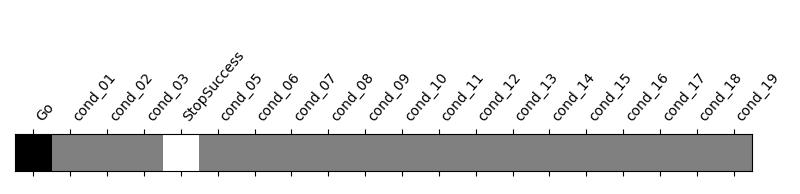

In [15]:
from IPython.display import Image

Image(filename='../outputs/6_glm/firstlevel_contrast.jpg')

#### Nilearn Z map

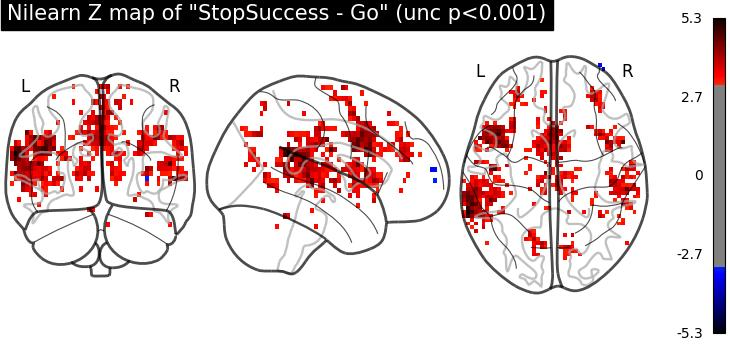

In [16]:
Image(filename='../outputs/6_glm/nilearn_z_map.jpg')

#### FSL Z map

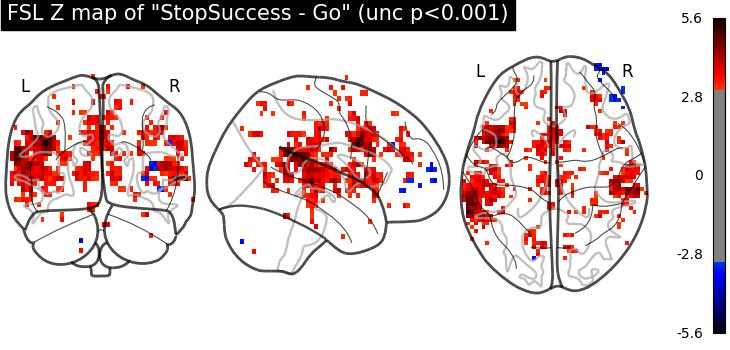

In [17]:
Image(filename='../outputs/6_glm/fsl_z_map.jpg')

#### Nilearn FSL comparison

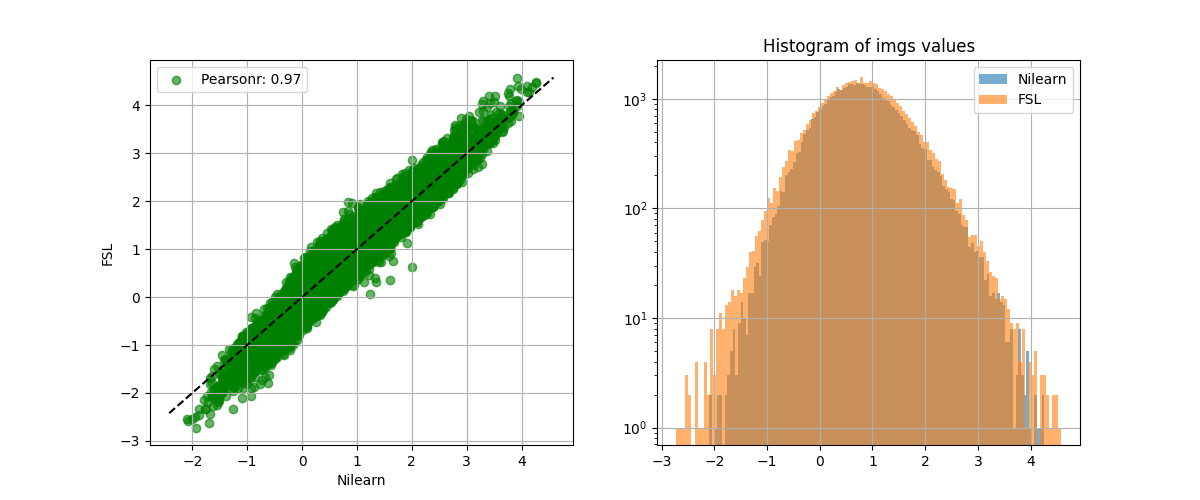

In [18]:
Image(filename='../outputs/6_glm/nilearn_fsl_comp.jpg')

## Exercise

What if we need to run the first-level GLM on multiple subject? We will need the `splitter`.

So, where should we add `.split`?